In [1]:
'''
This code generates box plots for richness indices, comparing different sample sizes using rarefaction.
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

In [32]:
#FUNCTIONS
def get_chao1(df, verbose=False):
    # Sample Data: Species names and their counts (can be from a DataFrame)
    # Let's assume this is a dataset with columns: 'species' and 'count'
    
    # Calculate F1 (singletons) and F2 (doubletons)
    F1 = (df['countSample'] == 1).sum()  # Number of species that appear exactly once
    F2 = (df['countSample'] == 2).sum()  # Number of species that appear exactly twice
    
    # Total observed species (S_obs)
    S_obs = df.shape[0]  # The number of unique species observed
    
    # Chao1 estimator formula
    S_Chao1 = S_obs + (F1 * (F1 - 1)) / (2 * (F2 + 1))
    if verbose:
    # Output the results
        print(f"Observed species (S_obs): {S_obs}")
        print(f"Singletons (F1): {F1}")
        print(f"Doubletons (F2): {F2}")
        print(f"Chao1 Estimate: {S_Chao1}")
    return S_Chao1

def get_chao2(df):
    # Pivot the dataframe to get species counts for each sample
    df_pivot = df.pivot(index='FlowCamID', columns='newName', values='countSample').fillna(0)
    
    # Convert the counts to boolean (0 = species absent, >0 = species present)
    species_counts = df_pivot.astype(bool).sum(axis=0)  # Number of samples each species appears in
    
    # Total number of observed species (S_obs)
    S_obs = len(species_counts)
    
    # Count the number of singletons (species observed exactly once across all samples)
    n1 = sum(1 for count in species_counts if count == 1)
    
    # Count the number of doubletons (species observed exactly twice across all samples)
    n2 = sum(1 for count in species_counts if count == 2)
    
    # Apply the Chao2 formula
    chao2 = S_obs + (n1 ** 2) / (2 * n2) if n2 > 0 else S_obs  # Avoid division by zero if n2 is zero
    
    return chao2


def get_increment(max_num, num_of_intervals):
    divider = max_num - max_num % num_of_intervals    
    return divider / num_of_intervals

def rarefaction_curve(df, max_sample_size, num_of_intervals, num_iterations=1000):
    print('num of species: ', len(df))
    print(df['newName'])
    newNames = df['newName'].to_numpy()
    probs = df['probs'].to_numpy()
    species_counts = df['countSample'].values  # Counts of each species
    name_basket = []
    for i, newName in enumerate(newNames):
        for _ in range(species_counts[i]):
            name_basket.append(newName)
    richness_list = []  # List to store species richness for each sample size
    increment = get_increment(max_sample_size, num_of_intervals)
    print("increment: ", increment)
    for sample_size in range(0, max_sample_size + 1):
        if not sample_size % increment == 0:
            continue
        species_richness = []

        for _ in range(num_iterations):
            # Randomly sample individuals from the species counts
            sampled =np.random.choice(name_basket, sample_size, replace=False)
            # Count the number of unique species observed in this random sample
            observed_species = len(np.unique(sampled))  # Species present if count > 0
            species_richness.append(observed_species)
        richness_list.append(np.mean(species_richness))
        # if np.mean(species_richness) >= len(df):
        #     break
        # Calculate the average species richness for the current sample size
        # print("mean of species_richness: ", np.mean(species_richness))
    return richness_list, increment

def get_rarefaction_value(df, sample_size, num_iterations):
    sum_counts = df['countSample'].sum()
    df['probs'] = df['countSample'] / sum_counts
    # print(df['newName'])
    newNames = df['newName'].to_numpy()
    probs = df['probs'].to_numpy()
    species_counts = df['countSample'].values  # Counts of each species
    name_basket = []
    for i, newName in enumerate(newNames):
        for _ in range(species_counts[i]):
            name_basket.append(newName)
    species_richness = []
    shannons = []
    pielous = []
    for _ in range(num_iterations):
        # Randomly sample individuals from the species counts
        sampled =np.random.choice(name_basket, sample_size, replace=False)
        # Count the number of unique species observed in this random sample
        observed_species = len(np.unique(sampled))  # Species present if count > 0
        species_richness.append(observed_species)
        
        taxa_counts = Counter(sampled)        
        # If you want to get a list of counts (sorted by label)
        counts_list = np.array(list(taxa_counts.values()))
        sample_shannon = shannon_diversity_index(counts_list)
        sample_pielou = pielou_evenness_index(counts_list)
        shannons.append(sample_shannon)
        pielous.append(sample_pielou)
    richness = np.mean(species_richness)
    shannon = np.mean(shannons)
    pielou = np.mean(pielous)
    return richness, shannon, pielou

def plot_rarefaction_curve(df, chao1, num_of_intervals):

    sum_counts = df['countSample'].sum()
    df['probs'] = df['countSample'] / sum_counts
    

    
    # Get the rarefaction curve
    richness, increment = rarefaction_curve(df, min(sum_counts, 8525), 200)
    # Plot the rarefaction curve
    plt.figure(figsize=(8, 6))
    plt.plot(np.array(range(len(richness))) * increment, richness)
    plt.axhline(y=chao1, color='red', linestyle='--', linewidth=2)
    plt.axhline(y=len(df), color='red', linestyle='-', linewidth=2)
    plt.title('Rarefaction Curve')
    plt.xlabel('Number of Individuals Sampled')
    plt.ylabel('Species Richness (Observed Species)')
    plt.grid(True)
    plt.show()
    plt.close()
    return richness, sum_counts, increment, len(df)

def get_redundant_count_names(abunddf, countdf, type):
    typeAbunddf = abunddf[abunddf['type'] == type]
    abundNames = typeAbunddf['newName'].unique()
    countNames = countdf['newName'].unique()
    unique_to_abund = np.setdiff1d(abundNames, countNames)
    unique_to_count = np.setdiff1d(countNames, abundNames)
    print("unique to abund: ", unique_to_abund)
    print("unique to count: ", unique_to_count)
    return unique_to_count


def shannon_diversity_index(species_counts):
    """
    Calculate the Shannon Diversity Index (H') for a given list of species counts.
    
    Parameters:
    species_counts (list or array): A list of counts for each species.

    Returns:
    float: The Shannon Diversity Index (H').
    """
    # Convert counts to proportions
    total_count = np.sum(species_counts)
    
    proportions = species_counts / total_count
    # Remove zero proportions to avoid log(0) issues
    proportions = proportions[proportions > 0]

    # Calculate Shannon index
    shannon_index = -np.sum(proportions * np.log(proportions))
    return shannon_index

def pielou_evenness_index(species_counts):
    """
    Calculate Pielou's Evenness Index (J') for a given list of species counts.
    
    Parameters:
    species_counts (list or array): A list of counts for each species.

    Returns:
    float: Pielou's Evenness Index (J').
    """
    # Total number of species (non-zero counts)
    S = np.sum(species_counts > 0)
    
    if S <= 1:
        # Evenness is undefined for 1 or fewer species
        return 0.0
    
    # Calculate Shannon Diversity Index
    H = shannon_diversity_index(species_counts)
    
    # Calculate Pielou's Evenness Index
    J = H / np.log(S)
    return J

'''FUNCTION FOR DISPLAYING BOXPLOTS
    data = the boxplot data
    ylim = the y-axis limits for the plots
    asterisk_indices = an array of which boxes (regionYears) have asterisks (significant differences)
    asterisk_locs = x and y locations of each asterisk within its subplot
    title = title of each subplot
    figuretitle = title of the whole plot
    return void
'''
def display_boxplots(data, ylim, asterisk_indices, asterisk_locs, title, figuretitle):
    print(data)
    regionYears = ['Gulf', 'Pacific', 'NL 2020', 'NL 2021']
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for r, regionYear in enumerate(regionYears):
        if regionYear == 'Gulf':
            types = ['CI-u', 'CI', 'HI', 'HM']
        else:
            types = ['CI', 'HI', 'HM']
        print(types)
        
        ax = axes[r]
        bplot = ax.boxplot(data[regionYear], patch_artist=True, medianprops=dict(color='blue', linewidth=2))
        # Set x-ticks labels for each boxplot
        colors = ['#75ba75', '#fec76f', '#be95be']
        if len(types) > 3:
            colors = ['#49f549', '#75ba75', '#fec76f', '#be95be']
        ax.set_xticks(range(1, len(types) + 1), types, fontsize=14)
        # ax.set_yticks([])
        # if regionYear != 'Gulf':
        #     ax.tick_params(axis='y', labelleft=False)  
        # ax.set_xticks()
        # Add title and labels
        ax.set_title(regionYear, fontsize=14)
        ax.set_ylim(ylim)
        
    # fill with colors
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        # ax.set_xlabel('Classification Method')
        # ax.set_ylabel('Number of Unique Taxa per Sample')
    
    # Set a single y-label on the left side for all subplots
    axes[0].set_ylabel(f"{title}\nper Sample", fontsize=14)
    for i, index in enumerate(asterisk_indices):
        print(i)
        print(asterisk_locs[i])
        axes[index].text(asterisk_locs[i][0], asterisk_locs[i][1], '*', fontsize=20, color='black', ha='center', va='center')
    
    # Set a single x-label at the bottom in the center for all subplots
    fig.text(0.5, -0.05, "Sorting Process", ha='center', va='center', fontsize=14)
    fig.text(0.1, 1, f"({figuretitle})", ha='right', va='center', fontsize=14)  
    # Show the plot
    plt.show()
    plt.close()

def test_assumptions(dataset, verbose=False):
    for regionYear in regionYears:
        for _ in range(3):
            print('#############################')
        print('-------------------', regionYear, '------------------------')
        for _ in range(3):
            print('#############################')
        if regionYear == 'Gulf':
            types = [1, 2, 3]
        else:
            types = [0, 1, 2]
        for type in types:
            print('----------------------------', regionYear, type)
            rawdata = dataset[regionYear][type]
            # print('before: ', rawdata)
            data = np.log(rawdata)
            # print('after: ', data)
            # print('before again: ', rawdata)
            if verbose:
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                # Plot the first histogram (normal distribution)
                axes[0].hist(rawdata, bins=30, color='blue', alpha=0.7)
                axes[0].set_title('Raw Data')
                axes[0].set_xlabel('Value')
                axes[0].set_ylabel('Frequency')
                # Plot the second histogram (log-normal distribution)
                axes[1].hist(data, bins=30, color='green', alpha=0.7)
                axes[1].set_title('Log-normal transform')
                axes[1].set_xlabel('Value')
                axes[1].set_ylabel('Frequency')
                plt.show()
                plt.close()
            # Perform the Shapiro-Wilk test
            statistic, p_value = stats.shapiro(rawdata)
            
            # Print results
            print(f"Shapiro-Wilk Test Statistic: {statistic}")
            print(f"P-value: {p_value}")
        
            # Interpret the result
            if p_value > 0.05:
                print(f"The data is normally distributed (p = {p_value:.3f})")
            else:
                print('NOT NORMAL----------------------------------------')
                print(f"The data is not normally distributed (p = {p_value:.3f})")
            # Perform the Shapiro-Wilk test
            print('------------------', 'AFTER LOG TRANSFORM', '-----------')
            statistic, p_value = stats.shapiro(data)
            
            # Print results
            print(f"Shapiro-Wilk Test Statistic: {statistic}")
            print(f"P-value: {p_value}")
        
            # Interpret the result
            if p_value > 0.05:
                print(f"The data is normally distributed (p = {p_value:.3f})")
            else:
                print('NOT NORMAL----------------------------------------')
                print(f"The data is not normally distributed (p = {p_value:.3f})")
        print('###########', 'Levene Time', '################')
        for combo in [[types[0], types[1]], [types[0], types[2]], [types[1], types[2]]]:
            
            # Perform Levene's test for homogeneity of variances
            stat, p_value = stats.levene(dataset[regionYear][combo[0]] , dataset[regionYear][combo[1]])
            # Print the test statistic and p-value
            print(f"Levene's test statistic: {stat}")
            print(f"P-value: {p_value*3}")
        print('Levene after Log Transform')
        for combo in [[0, 1], [0, 2], [1, 2]]:
            
            # Perform Levene's test for homogeneity of variances
            stat, p_value = stats.levene(np.log(dataset[regionYear][combo[0]]) , np.log(dataset[regionYear][combo[1]]))
            # Print the test statistic and p-value
            print(f"Levene's test statistic: {stat}")
            print(f"P-value: {p_value*3}")

def friedman_and_posthoc(datasets, name):
    print('------------------------')
    print(name)
    for regionYear in regionYears:
        print('-------------', regionYear, '-------------------')
        if regionYear == 'Gulf':
           # Example data (related groups)
            list1 = datasets[regionYear][1]
            list2 = datasets[regionYear][2]
            list3 = datasets[regionYear][3]
        else:
        # Example data (related groups)
            list1 = datasets[regionYear][0]
            list2 = datasets[regionYear][1]
            list3 = datasets[regionYear][2]
        
        # Step 1: Perform Friedman Test
        stat, p = friedmanchisquare(list1, list2, list3)
        print(f"Friedman Test: Chi-square statistic = {stat}, p-value = {p}")
        
        if p < 0.05:
            print("Significant differences found. Proceeding with pairwise comparisons.")
            
            # Step 2: Perform pairwise Wilcoxon Signed-Rank Tests
            data = [list1, list2, list3]
            labels = ['CI', 'HI', 'HM']
            comparisons = combinations(range(len(data)), 2)  # Generate pairwise indices
            
            for i, j in comparisons:
                # print(data[i], data[j])
                print(f"Mean of {labels[i]}: {np.mean(data[i])}, Mean of {labels[j]}: {np.mean(data[j])}")
                stat, p = wilcoxon(data[i], data[j])
                t_stat, t_p_value = stats.ttest_rel(data[i], data[j])
                print(f"Wilcoxon Test ({labels[i]} vs {labels[j]}): Statistic = {stat}, p-value = {p*3}")
                print(f"T Test ({labels[i]} vs {labels[j]}): Statistic = {t_stat}, p-value = {t_p_value*3}")
        else:
            print("No significant differences found. No need for pairwise comparisons.")

In [3]:

nameChangesFile = pd.ExcelFile('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/methodPaperZooNameChanges.xlsx')
sheet_names = nameChangesFile.sheet_names
nameChanges = pd.read_excel(nameChangesFile, sheet_names[1])
ogNames = nameChanges['flowcamName'].to_numpy()
newNames = nameChanges['newName'].to_numpy()
changeDict = {}
for i, ogname in enumerate(ogNames):
    changeDict[ogname] = newNames[i]

changeDict['Chaetognatha (juvenile or n.s.)']= 'Chaetognatha'
changeDict['Sarsia_spp_medusa']= 'Sarsia spp. (medusa)'


In [4]:
datadf = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/methodPaperDataForFigures.xlsx')

In [5]:
# this cleans the the redundant taxa from the microscopy data (like eggs)

hm_rawcounts_df = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/microscopyDataMethodPaper_RawCounts.xlsx')
hm_rawcounts_df = hm_rawcounts_df[['FlowCamID', 'newName', 'regionYear', 'Subsample fraction', 'countSample']]
#check which names are in rawcounts but not in the abundance data sheet. Remove them and print them.
hm_rawcounts_df_redundant_names = get_redundant_count_names(datadf, hm_rawcounts_df, 'MC')
print(len(hm_rawcounts_df['newName'].unique()))
hm_rawcounts_df = hm_rawcounts_df[~hm_rawcounts_df['newName'].isin(hm_rawcounts_df_redundant_names)]
len(hm_rawcounts_df['newName'].unique())

unique to abund:  []
unique to count:  ['Decapoda: Distribute abundances between non-brachyura and brachyura'
 'Egg mass: REMOVE' 'Invertebrate (egg, trochophore larvae)']
50


47

In [6]:
#rename problem taxa

newName_removals = ['Alciopidae sp.', 'Neoturris spp. (medusa)', 'Scyphozoa (medusa)']

newName_changes = {'Ctenophora (juvenile/adult)': 'Ctenophora (larvae)',
                  'Amphipoda- epibenthic': 'Amphipoda',
                   'Calycophorae (nectophore)': 'Siphonophorae (nectophore)',
                   'Ctenophora larvae': 'Ctenophora (larvae)'
                  }


hm_rawcounts_df = hm_rawcounts_df[~hm_rawcounts_df['newName'].isin(newName_removals)]
hm_rawcounts_df = hm_rawcounts_df.replace(newName_changes)
hm_rawcounts_df = hm_rawcounts_df.replace({'Gulf 2020': 'Gulf', 'Pac 21': 'Pacific' })
hm_names = hm_rawcounts_df['newName'].unique()
hm_names.sort()
print(len(hm_names))
hm_names

43


array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Amphipoda',
       'Ascidiacea (larvae)', 'Bivalvia (larvae)', 'Bryozoa (larvae)',
       'Calanoida (ci-ciii)', 'Calanus spp.', 'Centropages spp.',
       'Chaetognatha', 'Cirripedia (larvae)', 'Copepoda (nauplii)',
       'Corycaeidae', 'Ctenophora (larvae)',
       'Decapoda- brachyura (larvae)', 'Decapoda- non-brachyura (larvae)',
       'Echinodermata (larvae)', 'Epilabidocera spp.', 'Eurytemora spp.',
       'Evadne spp.', 'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)',
       'Isopoda (larvae)', 'Leuckartiara spp. (medusa)',
       'Microcalanus spp.', 'Obelia spp. (medusa)', 'Oikopleura spp.',
       'Oithona spp.', 'Osteichthyes (larvae)', 'Paracalanus spp.',
       'Platyhelminthes/Nemertea (juvenile)',
       'Platyhelminthes/Nemertea (larvae)', 'Podon/Pleopsis spp.',
       'Polychaeta (larvae)', 'Pseudocalanus spp.',
       'Pseudodiaptomus spp.', 'Sarsia spp. (me

In [7]:
sampleCounts = hm_rawcounts_df[['FlowCamID', 'countSample']].groupby('FlowCamID', as_index=False)['countSample'].sum()
smallest_sample = sampleCounts['countSample'].min()
print(smallest_sample)

hm_richness_dict = {}
hm_shannon_dict = {}
hm_pielou_dict = {}
regionYears = hm_rawcounts_df['regionYear'].unique()
for regionYear in regionYears:
    hm_richness_dict[regionYear] = []
    hm_shannon_dict[regionYear] = []
    hm_pielou_dict[regionYear] = []
    print('------------', regionYear, '------------')
    regionYear_df = hm_rawcounts_df[hm_rawcounts_df['regionYear'] == regionYear]
    samples = regionYear_df['FlowCamID'].unique()
    for sample in samples:
        sampledf = regionYear_df[regionYear_df['FlowCamID'] == sample]
        sample_counts = sampledf.groupby('newName', as_index=False)['countSample'].sum()
        # print(np.sum(sample_counts['countSample'].to_numpy()))
        chao1 = get_chao1(sample_counts)
        # print('sample size: ', sample_counts['countSample'].sum())
        richness, shannon, pielou = get_rarefaction_value(sample_counts, smallest_sample, 1000)
        print('richness: ', richness, 'shannon: ', shannon, 'pielou: ', pielou)
        hm_richness_dict[regionYear].append(richness)
        hm_shannon_dict[regionYear].append(shannon)
        hm_pielou_dict[regionYear].append(pielou)

203
------------ NL 2021 ------------
richness:  14.767 shannon:  1.878772909940818 pielou:  0.6989975101558115
richness:  14.833 shannon:  1.8863164808227455 pielou:  0.7008385075523266
richness:  15.84 shannon:  1.994028255120906 pielou:  0.7226554761728223
richness:  13.635 shannon:  1.7183765053157918 pielou:  0.6594366257015426
richness:  13.912 shannon:  1.712265545350478 pielou:  0.6517080465561835
richness:  15.589 shannon:  2.008012235090904 pielou:  0.7321680154895127
richness:  16.141 shannon:  1.9910173137614435 pielou:  0.7168225285898435
richness:  16.61 shannon:  2.008852734036869 pielou:  0.7160184221769389
richness:  13.993 shannon:  2.007671338524207 pielou:  0.7622721029942441
richness:  12.342 shannon:  1.8920536889697965 pielou:  0.7546076072569345
------------ NL 2020 ------------
richness:  7.996 shannon:  1.2554862741769552 pielou:  0.603921974395123
richness:  7.701 shannon:  1.1535210371784557 pielou:  0.5661486297975769
richness:  8.437 shannon:  1.2586654593

In [8]:
hi_rawcounts_df = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/flowcamDataMethodPaper_RawCounts.xlsx')
hi_rawcounts_df = hi_rawcounts_df[['qaSampleID', 'originalNames', 'dataset', 'fracSampleCleaned', 'count']]
hi_rawcounts_df = hi_rawcounts_df.rename(columns={'qaSampleID': 'FlowCamID', 'originalNames': 'newName', 'dataset':'regionYear', 'count': 'countSample'})
hi_rawcounts_df['newName'] = hi_rawcounts_df['newName'].replace(changeDict)
hi_rawcounts_df['regionYear'] = hi_rawcounts_df['regionYear'].replace({'Newfoundland 2020': 'NL 2020', 'Pacific June 2021': 'Pacific', 'Newfoundland 2021': 'NL 2021', 'Gulf 2020': 'Gulf'})
hi_rawcounts_df_redundant_names = get_redundant_count_names(datadf, hi_rawcounts_df, 'FC')
hi_rawcounts_df_redundant_names = hi_rawcounts_df_redundant_names[hi_rawcounts_df_redundant_names != 'Oncaeidae_Civ-vi']
hi_rawcounts_df_redundant_names = hi_rawcounts_df_redundant_names[hi_rawcounts_df_redundant_names != 'Sarsia spp. (medusa)']
print(len(hi_rawcounts_df['newName'].unique()))
hi_rawcounts_df = hi_rawcounts_df[~hi_rawcounts_df['newName'].isin(hi_rawcounts_df_redundant_names)]
print(len(hi_rawcounts_df['newName'].unique()))
hi_names = hi_rawcounts_df['newName'].unique()
hi_names.sort()
hi_names

unique to abund:  []
unique to count:  ['Calanoida (unid)' 'Copepoda (unid)' 'Cyclopoida (unid)'
 'Invertebrate (egg, trochophore larvae)' 'Oncaeidae_Civ-vi'
 'Osteichthyes egg' 'Osteichthyes_eggs' 'Sarsia spp. (medusa)'
 'Zooplankton (unid)']
55
48


array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Amphipoda',
       'Anthoathecata (medusa)', 'Ascidiacea (larvae)',
       'Bivalvia (larvae)', 'Bryozoa (larvae)', 'Calanoida (ci-ciii)',
       'Calanus spp.', 'Calycophorae (nectophore)', 'Centropages spp.',
       'Chaetognatha', 'Chiridius spp.', 'Cirripedia (larvae)',
       'Cnidaria (larvae)', 'Copepoda (nauplii)', 'Corycaeidae',
       'Ctenophora larvae', 'Decapoda- brachyura (larvae)',
       'Decapoda- non-brachyura (larvae)', 'Echinodermata (larvae)',
       'Euphysa spp. (medusa)', 'Eurytemora spp.', 'Evadne spp.',
       'Foraminifera', 'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)', 'Metridia spp.',
       'Microcalanus spp.', 'Microsetella spp.', 'Monstrillidae',
       'Obelia spp. (medusa)', 'Oikopleura spp.', 'Oithona spp.',
       'Oncaeidae_Civ-vi', 'Osteichthyes (larvae)', 'Ostracoda',
       'Paracalanus spp.', 'Podon/Pleopsis spp.', 'Polychaeta (larvae

In [9]:
sampleCounts = hi_rawcounts_df[['FlowCamID', 'countSample']].groupby('FlowCamID', as_index=False)['countSample'].sum()
smallest_sample = sampleCounts['countSample'].min()
print('smallest sample: ', smallest_sample)

hi_richness_dict = {}
hi_shannon_dict = {}
hi_pielou_dict = {}
regionYears = hi_rawcounts_df['regionYear'].unique()
for regionYear in regionYears:
    hi_richness_dict[regionYear] = []
    hi_shannon_dict[regionYear] = []
    hi_pielou_dict[regionYear] = []
    print('------------', regionYear, '------------')
    regionYear_df = hi_rawcounts_df[hi_rawcounts_df['regionYear'] == regionYear]
    samples = regionYear_df['FlowCamID'].unique()
    for sample in samples:
        sampledf = regionYear_df[regionYear_df['FlowCamID'] == sample]
        sample_counts = sampledf.groupby('newName', as_index=False)['countSample'].sum()
        # print(np.sum(sample_counts['countSample'].to_numpy()))
        chao1 = get_chao1(sample_counts)
        # print('sample size: ', sample_counts['countSample'].sum())
        richness, shannon, pielou = get_rarefaction_value(sample_counts, smallest_sample, 1000)
        print('richness: ', richness, 'shannon: ', shannon, 'pielou: ', pielou)
        hi_richness_dict[regionYear].append(richness)
        hi_shannon_dict[regionYear].append(shannon)
        hi_pielou_dict[regionYear].append(pielou)

smallest sample:  800
------------ NL 2020 ------------
richness:  9.747 shannon:  1.153548092303607 pielou:  0.5083993430722662
richness:  11.535 shannon:  1.151847089417855 pielou:  0.47340234824351995
richness:  11.349 shannon:  1.3284694384292453 pielou:  0.5484778392621663
richness:  10.78 shannon:  1.2846445474976138 pielou:  0.5435300838080187
richness:  12.52 shannon:  1.3597824958914457 pielou:  0.540340967553035
richness:  13.667 shannon:  1.2734149607765568 pielou:  0.4889428630300943
richness:  13.087 shannon:  1.335227621410059 pielou:  0.5203145292319553
richness:  11.583 shannon:  1.2582169369207095 pielou:  0.5161557856742295
richness:  13.165 shannon:  1.414299077041036 pielou:  0.5503020542433434
richness:  12.634 shannon:  1.2857240859422185 pielou:  0.5095651462766689
------------ NL 2021 ------------
richness:  21.934 shannon:  1.9277181801844794 pielou:  0.6242754930312476
richness:  19.619 shannon:  1.8980820079957543 pielou:  0.6378516352868889
richness:  23.836

In [10]:
cidf = pd.read_excel('five_thousand_strat4_abunds_Feb4.xlsx')
cidf = cidf[cidf['type'] == 'CI']
ci_rawcounts_df = cidf.rename(columns={'abund': 'countSample'})
ci_rawcounts_df = ci_rawcounts_df.replace(newName_changes)
ci_rawcounts_df = ci_rawcounts_df.replace({'Gulf 2020': 'Gulf', 'Pac 21': 'Pacific' })

In [11]:
sampleCounts = ci_rawcounts_df[['FlowCamID', 'countSample']].groupby('FlowCamID', as_index=False)['countSample'].sum()
smallest_sample = sampleCounts['countSample'].min()
smallest_sample = int(smallest_sample)
print('smallest sample: ', smallest_sample)
ci_samples = {}
ci_richness_dict = {}
ci_shannon_dict = {}
ci_pielou_dict = {}
regionYears = ci_rawcounts_df['regionYear'].unique()
for regionYear in regionYears:
    ci_richness_dict[regionYear] = []
    ci_shannon_dict[regionYear] = []
    ci_pielou_dict[regionYear] = []
    ci_samples[regionYear] = []
    print('------------', regionYear, '------------')
    regionYear_df = ci_rawcounts_df[ci_rawcounts_df['regionYear'] == regionYear]
    samples = regionYear_df['FlowCamID'].unique()
    for sample in samples:
        ci_samples[regionYear].append(sample)
        sampledf = regionYear_df[regionYear_df['FlowCamID'] == sample]
        sample_counts = sampledf.groupby('newName', as_index=False)['countSample'].sum()
        sample_counts['countSample'] = sample_counts['countSample'].astype(int)
        # print(np.sum(sample_counts['countSample'].to_numpy()))
        chao1 = get_chao1(sample_counts)
        # print('sample size: ', sample_counts['countSample'].sum())
        richness, shannon, pielou = get_rarefaction_value(sample_counts, smallest_sample, 1000)
        print('richness: ', richness, 'shannon: ', shannon, 'pielou: ', pielou)
        ci_richness_dict[regionYear].append(richness)
        ci_shannon_dict[regionYear].append(shannon)
        ci_pielou_dict[regionYear].append(pielou)

smallest sample:  786
------------ NL 2021 ------------
richness:  20.989 shannon:  1.954985204670238 pielou:  0.6422466023081477
richness:  20.855 shannon:  1.9782498136736641 pielou:  0.6513048908984227
richness:  20.896 shannon:  2.1301381290896986 pielou:  0.7008465149161743
richness:  20.0 shannon:  2.035091447553412 pielou:  0.6793302143582671
richness:  21.758 shannon:  2.04568332176364 pielou:  0.6642643361678124
richness:  22.947 shannon:  2.1343991449976563 pielou:  0.6812386866065563
richness:  21.865 shannon:  2.014252619250464 pielou:  0.6529806826866111
richness:  20.0 shannon:  2.171849577217942 pielou:  0.7249811995520431
richness:  19.87 shannon:  2.155017239907704 pielou:  0.7209921839624401
richness:  19.84 shannon:  2.0733151235248224 pielou:  0.6940196278831755
------------ Gulf ------------
richness:  22.355 shannon:  1.7468833151578995 pielou:  0.5627730479074191
richness:  21.914 shannon:  2.2457155581045183 pielou:  0.7281098705141348
richness:  20.898 shannon:

In [12]:
ci_samples

{'NL 2021': ['21_10_05_NL_S1_Z17_0752_250',
  '21_10_05_NL_S1_Z17_1406_250',
  '21_10_05_NL_S1_Z41_0854_250',
  '21_10_05_NL_S1_Z41_1327_250',
  '21_10_06_NL_S1_Z17_0802_250',
  '21_10_06_NL_S1_Z17_1442_250',
  '21_10_06_NL_S1_Z41_0839_250',
  '21_10_06_NL_S1_Z41_1412_250',
  '21_10_07_NL_S1_Z17_0830_250',
  '21_10_07_NL_S1_Z17_1459_250'],
 'Gulf': ['AMMP_Gulf_StPeters_1_20200903HT_250UM',
  'AMMP_Gulf_StPeters_1_20200903LT_250UM',
  'AMMP_Gulf_StPeters_1_20200904HT_250UM',
  'AMMP_Gulf_StPeters_2B_20200903_250UM',
  'AMMP_Gulf_StPeters_2_20200903HT_250UM',
  'AMMP_Gulf_StPeters_2_20200904HT_250UM',
  'AMMP_Gulf_StPeters_3B_20200903_250UM',
  'AMMP_Gulf_StPeters_3_20200903HT_250UM',
  'AMMP_Gulf_StPeters_3_20200903LT_250UM',
  'AMMP_Gulf_StPeters_3_20200904HT_250UM'],
 'NL 2020': ['AMMP_NL_S01_33_20200916AM_250UM',
  'AMMP_NL_S01_33_20200916PM_250UM',
  'AMMP_NL_S01_41_20200916AM_250UM',
  'AMMP_NL_S01_41_20200916PM_250UM',
  'AMMP_NL_S01_51_20200915PM_250UM',
  'AMMP_NL_S01_51_2020091

In [13]:
%store ci_samples
%store ci_richness_dict
%store ci_shannon_dict
%store ci_pielou_dict

Stored 'ci_samples' (dict)
Stored 'ci_richness_dict' (dict)
Stored 'ci_shannon_dict' (dict)
Stored 'ci_pielou_dict' (dict)


In [14]:

max_cidf = pd.read_excel('max_strat4_abunds_Feb4.xlsx')
max_cidf = max_cidf[max_cidf['type'] == 'CI']
max_ci_rawcounts_df = max_cidf.rename(columns={'abund': 'countSample'})
max_ci_rawcounts_df = max_ci_rawcounts_df.replace(newName_changes)
max_ci_rawcounts_df = max_ci_rawcounts_df.replace({'Gulf 2020': 'Gulf', 'Pac 21': 'Pacific' })

In [15]:
sampleCounts = max_ci_rawcounts_df[['FlowCamID', 'countSample']].groupby('FlowCamID', as_index=False)['countSample'].sum()
smallest_sample = sampleCounts['countSample'].min()
smallest_sample = int(smallest_sample)
print('smallest sample: ', smallest_sample)

max_ci_richness_dict = {}
max_ci_shannon_dict = {}
max_ci_pielou_dict = {}
regionYears = max_ci_rawcounts_df['regionYear'].unique()
for regionYear in regionYears:
    max_ci_richness_dict[regionYear] = []
    max_ci_shannon_dict[regionYear] = []
    max_ci_pielou_dict[regionYear] = []
    print('------------', regionYear, '------------')
    regionYear_df = max_ci_rawcounts_df[max_ci_rawcounts_df['regionYear'] == regionYear]
    samples = regionYear_df['FlowCamID'].unique()
    for sample in samples:
        sampledf = regionYear_df[regionYear_df['FlowCamID'] == sample]
        sample_counts = sampledf.groupby('newName', as_index=False)['countSample'].sum()
        sample_counts['countSample'] = sample_counts['countSample'].astype(int)
        # print(np.sum(sample_counts['countSample'].to_numpy()))
        chao1 = get_chao1(sample_counts)
        # print('sample size: ', sample_counts['countSample'].sum())
        richness, shannon, pielou = get_rarefaction_value(sample_counts, smallest_sample, 1000)
        print('richness: ', richness, 'shannon: ', shannon, 'pielou: ', pielou)
        max_ci_richness_dict[regionYear].append(richness)
        max_ci_shannon_dict[regionYear].append(shannon)
        max_ci_pielou_dict[regionYear].append(pielou)

smallest sample:  786
------------ NL 2021 ------------
richness:  19.997 shannon:  1.9368711690356604 pielou:  0.6465771442119621
richness:  20.747 shannon:  1.934172836244158 pielou:  0.6379193205956656
richness:  20.813 shannon:  2.116530362717572 pielou:  0.6973149188387617
richness:  18.0 shannon:  2.020451827935526 pielou:  0.6990283593852187
richness:  21.781 shannon:  2.0428407729861915 pielou:  0.663109464774521
richness:  22.949 shannon:  2.1273133913290825 pielou:  0.6789569485068746
richness:  21.779 shannon:  2.008285245704001 pielou:  0.6519081851552873
richness:  20.979 shannon:  2.1642829994374297 pielou:  0.7111202530885232
richness:  19.867 shannon:  2.141762821143185 pielou:  0.7165968889181745
richness:  18.85 shannon:  2.0670467712923775 pielou:  0.703986850823054
------------ Gulf ------------
richness:  19.661 shannon:  1.6986715527534078 pielou:  0.5709651866186539
richness:  17.267 shannon:  1.7188024586940724 pielou:  0.6045081081662732
richness:  19.408 shann

In [16]:
richness_box_data = {}
shannon_box_data = {}
pielou_box_data = {}
for regionYear in regionYears:
    richness_box_data[regionYear] = []
    if regionYear == 'Gulf':
        richness_box_data[regionYear].append(max_ci_richness_dict[regionYear])
    richness_box_data[regionYear].append(ci_richness_dict[regionYear])
    richness_box_data[regionYear].append(hi_richness_dict[regionYear])
    richness_box_data[regionYear].append(hm_richness_dict[regionYear])

    shannon_box_data[regionYear] = []
    if regionYear == 'Gulf':
        shannon_box_data[regionYear].append(max_ci_shannon_dict[regionYear])
    shannon_box_data[regionYear].append(ci_shannon_dict[regionYear])
    shannon_box_data[regionYear].append(hi_shannon_dict[regionYear])
    shannon_box_data[regionYear].append(hm_shannon_dict[regionYear])

    pielou_box_data[regionYear] = []
    if regionYear == 'Gulf':
        pielou_box_data[regionYear].append(max_ci_pielou_dict[regionYear])
    pielou_box_data[regionYear].append(ci_pielou_dict[regionYear])
    pielou_box_data[regionYear].append(hi_pielou_dict[regionYear])
    pielou_box_data[regionYear].append(hm_pielou_dict[regionYear])


In [17]:
def get_mean_and_se(dataset):
    regionYears = ['Gulf', 'Pacific', 'NL 2020', 'NL 2021']
    for regionYear in regionYears:
        print('---------------', regionYear, '--------------')
        type_num = len(dataset[regionYear])
        if type_num > 3:
            types = ['CI-u', 'CI', 'HI', 'HM']
        else:
            types = ['CI', 'HI', 'HM']
        for t, type in enumerate(types):
            print('###', type, '###')
            datarow = dataset[regionYear][t]
            print("mean: ", np.mean(datarow))
            se = np.std(datarow, ddof=1)/np.sqrt(len(datarow))
            print("se: ", se)

get_mean_and_se(richness_box_data)

--------------- Gulf --------------
### CI-u ###
mean:  17.0219
se:  0.5209504017765139
### CI ###
mean:  20.8142
se:  0.37551102365827926
### HI ###
mean:  11.2198
se:  1.3111408670823026
### HM ###
mean:  9.562999999999999
se:  1.124566602938414
--------------- Pacific --------------
### CI ###
mean:  23.541500000000003
se:  0.2598387641083087
### HI ###
mean:  22.610500000000002
se:  0.3712683740309098
### HM ###
mean:  20.639499999999998
se:  0.4026812152449019
--------------- NL 2020 --------------
### CI ###
mean:  16.6226
se:  0.2790726787057449
### HI ###
mean:  12.006699999999999
se:  0.38539898662151256
### HM ###
mean:  9.2236
se:  0.4909283767629561
--------------- NL 2021 --------------
### CI ###
mean:  20.902
se:  0.327821428355269
### HI ###
mean:  21.0839
se:  0.4696036496640308
### HM ###
mean:  14.766200000000001
se:  0.4164404399190836


In [18]:
get_mean_and_se(shannon_box_data)

--------------- Gulf --------------
### CI-u ###
mean:  1.632869489328756
se:  0.07356437983862207
### CI ###
mean:  1.9827745546192361
se:  0.06270967063017927
### HI ###
mean:  1.135846029233527
se:  0.1289309549157246
### HM ###
mean:  1.4209221723841954
se:  0.10804277011543788
--------------- Pacific --------------
### CI ###
mean:  2.180372155378466
se:  0.01583935449468824
### HI ###
mean:  2.0004549890641767
se:  0.03694004994837984
### HM ###
mean:  2.284243664869821
se:  0.031568067851462656
--------------- NL 2020 --------------
### CI ###
mean:  1.8475067971900774
se:  0.01729460301267379
### HI ###
mean:  1.2845174345630346
se:  0.02636964758401079
### HM ###
mean:  1.3063509905500799
se:  0.03800639719659735
--------------- NL 2021 --------------
### CI ###
mean:  2.069298162164924
se:  0.024022062627421462
### HI ###
mean:  1.9673756961477538
se:  0.03017070577637496
### HM ###
mean:  1.9097367006933958
se:  0.0365480505225706


In [19]:
get_mean_and_se(pielou_box_data)

--------------- Gulf --------------
### CI-u ###
mean:  0.5772975599633531
se:  0.02417692913546269
### CI ###
mean:  0.6544401809879743
se:  0.0214314956484566
### HI ###
mean:  0.4752449222673974
se:  0.035195699447391295
### HM ###
mean:  0.6478235073924868
se:  0.027235702535044443
--------------- Pacific --------------
### CI ###
mean:  0.6904516971057065
se:  0.0035975087669266
### HI ###
mean:  0.6417571630273574
se:  0.010367792679981471
### HM ###
mean:  0.7557808034503701
se:  0.010266840462777385
--------------- NL 2020 --------------
### CI ###
mean:  0.6586982347713604
se:  0.0062754631888695825
### HI ###
mean:  0.5199430960395298
se:  0.008226525172064732
### HM ###
mean:  0.5920159793256666
se:  0.010226654862634101
--------------- NL 2021 --------------
### CI ###
mean:  0.681220493933965
se:  0.009158035002798073
### HI ###
mean:  0.645849663341249
se:  0.008120553000656512
### HM ###
mean:  0.7115524842646159
se:  0.011349035189466032


{'NL 2021': [[20.989, 20.855, 20.896, 20.0, 21.758, 22.947, 21.865, 20.0, 19.87, 19.84], [21.934, 19.619, 23.836, 19.0, 22.668, 19.73, 20.594, 20.974, 21.699, 20.785], [14.767, 14.833, 15.84, 13.635, 13.912, 15.589, 16.141, 16.61, 13.993, 12.342]], 'Gulf': [[19.661, 17.267, 19.408, 15.918, 16.016, 16.559, 15.227, 15.121, 18.503, 16.539], [22.355, 21.914, 20.898, 21.416, 18.812, 20.78, 19.946, 19.265, 22.063, 20.693], [8.962, 6.663, 16.234, 10.69, 7.022, 10.006, 16.724, 17.778, 9.981, 8.138], [8.016, 4.77, 11.612, 7.419, 8.792, 8.133, 14.597, 16.029, 9.829, 6.433]], 'NL 2020': [[16.895, 17.54, 17.517, 17.024, 16.498, 16.113, 17.29, 14.723, 15.76, 16.866], [9.747, 11.535, 11.349, 10.78, 12.52, 13.667, 13.087, 11.583, 13.165, 12.634], [7.996, 7.701, 8.437, 8.707, 10.697, 9.293, 10.58, 8.334, 12.491, 8.0]], 'Pacific': [[23.206, 23.6, 23.253, 24.448, 24.671, 21.713, 23.916, 23.64, 23.11, 23.858], [24.563, 22.346, 21.29, 22.731, 22.768, 21.423, 24.293, 22.405, 21.138, 23.148], [20.286, 22.86

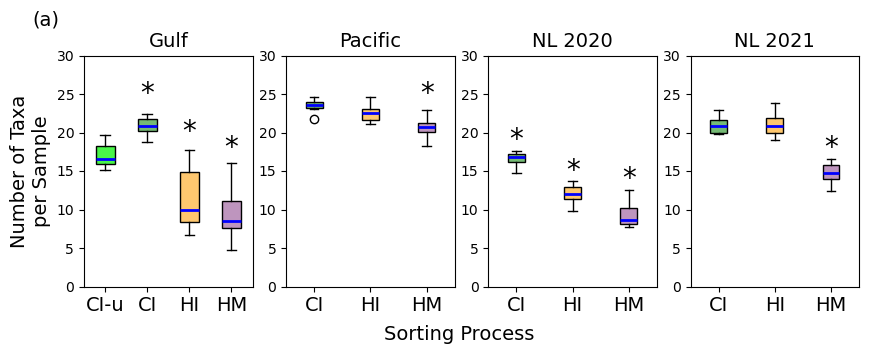

{'NL 2021': [[20.989, 20.855, 20.896, 20.0, 21.758, 22.947, 21.865, 20.0, 19.87, 19.84], [21.934, 19.619, 23.836, 19.0, 22.668, 19.73, 20.594, 20.974, 21.699, 20.785], [14.767, 14.833, 15.84, 13.635, 13.912, 15.589, 16.141, 16.61, 13.993, 12.342]], 'Gulf': [[19.661, 17.267, 19.408, 15.918, 16.016, 16.559, 15.227, 15.121, 18.503, 16.539], [22.355, 21.914, 20.898, 21.416, 18.812, 20.78, 19.946, 19.265, 22.063, 20.693], [8.962, 6.663, 16.234, 10.69, 7.022, 10.006, 16.724, 17.778, 9.981, 8.138], [8.016, 4.77, 11.612, 7.419, 8.792, 8.133, 14.597, 16.029, 9.829, 6.433]], 'NL 2020': [[16.895, 17.54, 17.517, 17.024, 16.498, 16.113, 17.29, 14.723, 15.76, 16.866], [9.747, 11.535, 11.349, 10.78, 12.52, 13.667, 13.087, 11.583, 13.165, 12.634], [7.996, 7.701, 8.437, 8.707, 10.697, 9.293, 10.58, 8.334, 12.491, 8.0]], 'Pacific': [[23.206, 23.6, 23.253, 24.448, 24.671, 21.713, 23.916, 23.64, 23.11, 23.858], [24.563, 22.346, 21.29, 22.731, 22.768, 21.423, 24.293, 22.405, 21.138, 23.148], [20.286, 22.86

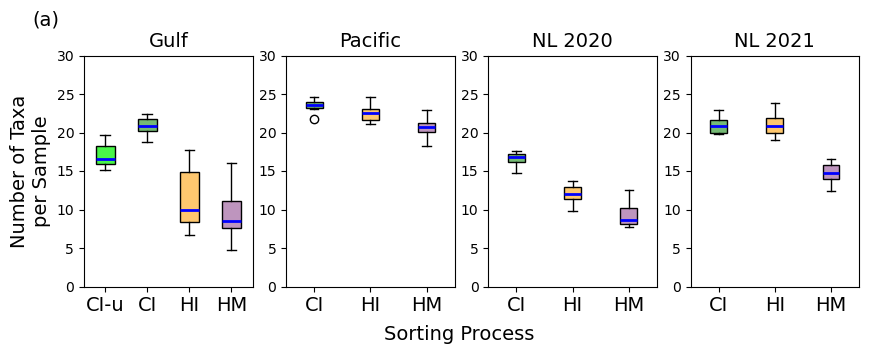

In [56]:
display_boxplots(richness_box_data, [0, 30], [0, 0, 0, 1, 2, 2, 2, 3], 
                 [[2, 25], [3, 20], [4, 18],
                  [3, 25], 
                  [1, 19], [2, 15], [3, 14], 
                  [3, 18]],
                 'Number of Taxa', 'a')

display_boxplots(richness_box_data, [0, 30], [], 
                 [],
                 'Number of Taxa', 'a')

In [21]:
regionYears = ['Gulf', 'Pacific', 'NL 2020', 'NL 2021']

In [53]:
test_assumptions(richness_box_data, False)

#############################
#############################
#############################
------------------- Gulf ------------------------
#############################
#############################
#############################
---------------------------- Gulf 1
Shapiro-Wilk Test Statistic: 0.9479590666371529
P-value: 0.6444193170645229
The data is normally distributed (p = 0.644)
------------------ AFTER LOG TRANSFORM -----------
Shapiro-Wilk Test Statistic: 0.9427820752971485
P-value: 0.5843650163415488
The data is normally distributed (p = 0.584)
---------------------------- Gulf 2
Shapiro-Wilk Test Statistic: 0.8573182578180274
P-value: 0.0709426153495056
The data is normally distributed (p = 0.071)
------------------ AFTER LOG TRANSFORM -----------
Shapiro-Wilk Test Statistic: 0.9038768675308132
P-value: 0.24152047332099902
The data is normally distributed (p = 0.242)
---------------------------- Gulf 3
Shapiro-Wilk Test Statistic: 0.930825829245717
P-value: 0.456064173981285
T

In [33]:

friedman_and_posthoc(richness_box_data, 'RICHNESS')

# friedman_and_posthoc(pielou_box_data, 'PIELOU')

------------------------
RICHNESS
------------- Gulf -------------------
Friedman Test: Chi-square statistic = 18.200000000000017, p-value = 0.0001116658084901137
Significant differences found. Proceeding with pairwise comparisons.
Mean of CI: 20.8142, Mean of HI: 11.2198
Wilcoxon Test (CI vs HI): Statistic = 0.0, p-value = 0.005859375
T Test (CI vs HI): Statistic = 6.443877666533794, p-value = 0.0003569716282608607
Mean of CI: 20.8142, Mean of HM: 9.562999999999999
Wilcoxon Test (CI vs HM): Statistic = 0.0, p-value = 0.005859375
T Test (CI vs HM): Statistic = 8.229567523351841, p-value = 5.2933084945707494e-05
Mean of HI: 11.2198, Mean of HM: 9.562999999999999
Wilcoxon Test (HI vs HM): Statistic = 5.0, p-value = 0.05859375
T Test (HI vs HM): Statistic = 3.068082938634491, p-value = 0.04018630581113891
------------- Pacific -------------------
Friedman Test: Chi-square statistic = 12.800000000000011, p-value = 0.0016615572731739255
Significant differences found. Proceeding with pairwis

In [24]:
test_assumptions(shannon_box_data, False)

#############################
#############################
#############################
------------------- Gulf ------------------------
#############################
#############################
#############################
---------------------------- Gulf 1
Shapiro-Wilk Test Statistic: 0.9468008359724134
P-value: 0.6308320261315588
The data is normally distributed (p = 0.631)
------------------ AFTER LOG TRANSFORM -----------
Shapiro-Wilk Test Statistic: 0.9390280201630663
P-value: 0.5422494942248999
The data is normally distributed (p = 0.542)
---------------------------- Gulf 2
Shapiro-Wilk Test Statistic: 0.8685602191034436
P-value: 0.0961726340684584
The data is normally distributed (p = 0.096)
------------------ AFTER LOG TRANSFORM -----------
Shapiro-Wilk Test Statistic: 0.92828542861326
P-value: 0.43124103307095196
The data is normally distributed (p = 0.431)
---------------------------- Gulf 3
Shapiro-Wilk Test Statistic: 0.711654667833592
P-value: 0.0012197139816263612

In [25]:
friedman_and_posthoc(shannon_box_data, 'SHANNON')

------------------------
SHANNON
------------- Gulf -------------------
Friedman Test: Chi-square statistic = 11.400000000000006, p-value = 0.003345965457471265
Significant differences found. Proceeding with pairwise comparisons.
Mean of CI: 1.9827745546192361, Mean of HI: 1.135846029233527
Wilcoxon Test (CI vs HI): Statistic = 1.0, p-value = 0.01171875
Mean of CI: 1.9827745546192361, Mean of HM: 1.4209221723841954
Wilcoxon Test (CI vs HM): Statistic = 2.0, p-value = 0.017578125
Mean of HI: 1.135846029233527, Mean of HM: 1.4209221723841954
Wilcoxon Test (HI vs HM): Statistic = 3.0, p-value = 0.029296875
------------- Pacific -------------------
Friedman Test: Chi-square statistic = 14.599999999999994, p-value = 0.0006755387751938461
Significant differences found. Proceeding with pairwise comparisons.
Mean of CI: 2.180372155378466, Mean of HI: 2.0004549890641767
Wilcoxon Test (CI vs HI): Statistic = 1.0, p-value = 0.01171875
Mean of CI: 2.180372155378466, Mean of HM: 2.284243664869821
W

{'NL 2021': [[1.954985204670238, 1.9782498136736641, 2.1301381290896986, 2.035091447553412, 2.04568332176364, 2.1343991449976563, 2.014252619250464, 2.171849577217942, 2.155017239907704, 2.0733151235248224], [1.9277181801844794, 1.8980820079957543, 2.1913111900615947, 1.9520290873290025, 1.915866982537873, 1.9403790403140662, 1.8419282644476325, 2.0421043215412076, 1.9858023505813172, 1.9785355364846093], [1.878772909940818, 1.8863164808227455, 1.994028255120906, 1.7183765053157918, 1.712265545350478, 2.008012235090904, 1.9910173137614435, 2.008852734036869, 2.007671338524207, 1.8920536889697965]], 'Gulf': [[1.6986715527534078, 1.7188024586940724, 1.6211874092718321, 1.2910081360616616, 1.7112643738517286, 1.4277241131098126, 1.444413885285092, 1.7926834465613706, 2.115815010328545, 1.5071245073700383], [1.7468833151578995, 2.2457155581045183, 1.6322342321132015, 1.9302435743975284, 2.0958052450982616, 1.9184486143548816, 1.9272205942292626, 2.1341904470648725, 2.2284868425898345, 1.96

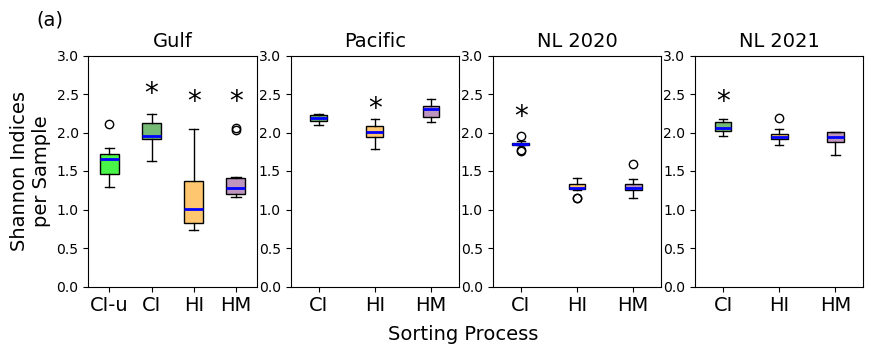

In [26]:
display_boxplots(shannon_box_data, [0, 3], [0, 0, 0, 1, 2, 3], 
                 [[2, 2.5], [3, 2.4], [4, 2.4],
                  [2, 2.3], 
                  [1, 2.2], 
                  [1, 2.4]],
                 'Shannon Indices', 'a')

In [54]:
test_assumptions(pielou_box_data, False)

#############################
#############################
#############################
------------------- Gulf ------------------------
#############################
#############################
#############################
---------------------------- Gulf 1
Shapiro-Wilk Test Statistic: 0.8870112390036453
P-value: 0.15689022195224933
The data is normally distributed (p = 0.157)
------------------ AFTER LOG TRANSFORM -----------
Shapiro-Wilk Test Statistic: 0.8807809010374746
P-value: 0.13321434157231693
The data is normally distributed (p = 0.133)
---------------------------- Gulf 2
Shapiro-Wilk Test Statistic: 0.8908778830379833
P-value: 0.17347749606704516
The data is normally distributed (p = 0.173)
------------------ AFTER LOG TRANSFORM -----------
Shapiro-Wilk Test Statistic: 0.9358276851400092
P-value: 0.5075865137266764
The data is normally distributed (p = 0.508)
---------------------------- Gulf 3
Shapiro-Wilk Test Statistic: 0.9343550015176373
P-value: 0.49206617668097

In [60]:
friedman_and_posthoc(pielou_box_data, 'PIELOU')

------------------------
PIELOU
------------- Gulf -------------------
Friedman Test: Chi-square statistic = 13.400000000000006, p-value = 0.0012309119026734777
Significant differences found. Proceeding with pairwise comparisons.
Mean of CI: 0.6544401809879743, Mean of HI: 0.4752449222673974
Wilcoxon Test (CI vs HI): Statistic = 2.0, p-value = 0.017578125
T Test (CI vs HI): Statistic = 4.121635190149296, p-value = 0.00777483773661487
Mean of CI: 0.6544401809879743, Mean of HM: 0.6478235073924868
Wilcoxon Test (CI vs HM): Statistic = 24.0, p-value = 2.30859375
T Test (CI vs HM): Statistic = 0.2463164763896343, p-value = 2.432889639958397
Mean of HI: 0.4752449222673974, Mean of HM: 0.6478235073924868
Wilcoxon Test (HI vs HM): Statistic = 0.0, p-value = 0.005859375
T Test (HI vs HM): Statistic = -5.306479383732117, p-value = 0.0014689394922101006
------------- Pacific -------------------
Friedman Test: Chi-square statistic = 18.200000000000017, p-value = 0.0001116658084901137
Significant 

{'NL 2021': [[0.6422466023081477, 0.6513048908984227, 0.7008465149161743, 0.6793302143582671, 0.6642643361678124, 0.6812386866065563, 0.6529806826866111, 0.7249811995520431, 0.7209921839624401, 0.6940196278831755], [0.6242754930312476, 0.6378516352868889, 0.6910501495770074, 0.6629545054730989, 0.613957762501037, 0.6507744165111466, 0.6090444897114458, 0.6710300364562943, 0.6454138063734649, 0.6521443384908582], [0.6989975101558115, 0.7008385075523266, 0.7226554761728223, 0.6594366257015426, 0.6517080465561835, 0.7321680154895127, 0.7168225285898435, 0.7160184221769389, 0.7622721029942441, 0.7546076072569345]], 'Gulf': [[0.5709651866186539, 0.6045081081662732, 0.5472044951895709, 0.46754011859847006, 0.6177186486129497, 0.5096124800388033, 0.531269025494905, 0.6607524464866082, 0.7256601592948879, 0.5377449311324087], [0.5627730479074191, 0.7281098705141348, 0.5374156775011913, 0.630560037679932, 0.7149504049115355, 0.6329954349040541, 0.6444385027751938, 0.7221147963824559, 0.72094316

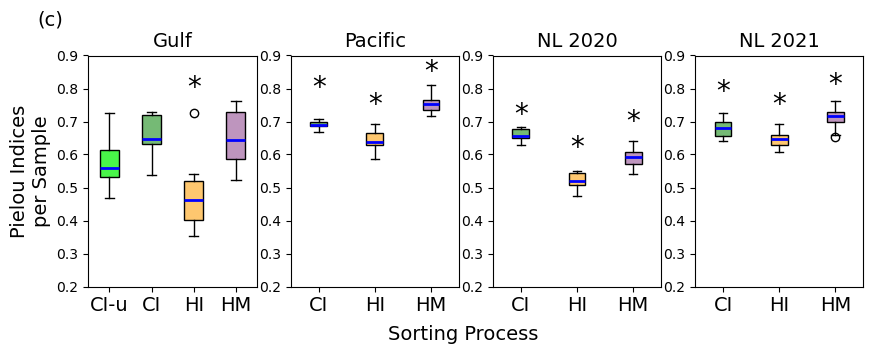

In [63]:
display_boxplots(pielou_box_data, [0.2, 0.9], [0, 1, 1, 1, 2, 2, 2, 3, 3, 3], 
                 [[3, .8],
                  [1, 0.8], [2, 0.75], [3, 0.85], 
                  [1, 0.72], [2, 0.62], [3, 0.70], 
                  [1, 0.79], [2, 0.75], [3, 0.81]],
                 'Pielou Indices', 'c')

In [165]:
regional_richness = {}
for regionYear in regionYears:
    regional_richness[regionYear] = []
    if regionYear == 'Gulf':
        regional_richness[regionYear].append(len(max_ci_rawcounts_df[max_ci_rawcounts_df['regionYear'] == regionYear]['newName'].unique()))
    regional_richness[regionYear].append(len(ci_rawcounts_df[ci_rawcounts_df['regionYear'] == regionYear]['newName'].unique()))
    regional_richness[regionYear].append(len(hi_rawcounts_df[hi_rawcounts_df['regionYear'] == regionYear]['newName'].unique()))
    regional_richness[regionYear].append(len(hm_rawcounts_df[hm_rawcounts_df['regionYear'] == regionYear]['newName'].unique()))
regional_richness

{'Gulf': [26, 29, 32, 21],
 'Pacific': [25, 29, 37],
 'NL 2020': [24, 27, 16],
 'NL 2021': [24, 29, 25]}

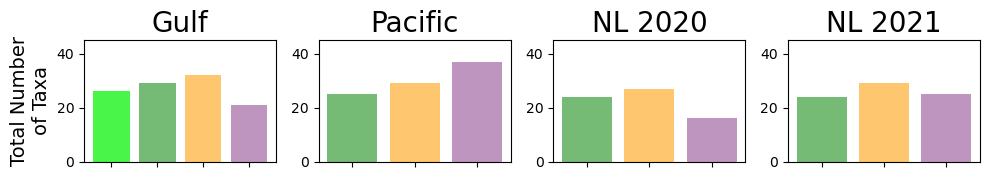

In [166]:
#small bar graphs for total species richness in all ten samples for each sorting process and regionYear
fig, axes = plt.subplots(1, 4, figsize=(10, 2))

# Loop through each regionYear and corresponding subplot
for i, regionYear in enumerate(regionYears):
    ax = axes[i]  # Access the correct subplot
    if i == 0:
        colors = ['#49f549', '#75ba75', '#fec76f', '#be95be']
        thisRichness = regional_richness[regionYear]
        ax.bar([1, 2, 3, 4], thisRichness, color=colors)
        ax.set_xticks([1, 2, 3, 4], [])
    # Create the bar plot in the current subplot
    else:
        colors = ['#75ba75', '#fec76f', '#be95be']
        ax.bar([1, 2, 3], regional_richness[regionYear], color=colors)
        ax.set_xticks([1, 2, 3], ['' for type in [1, 2, 3]])
    ax.set_title(regionYear, fontsize=20)  # Set the title for the subplot
    # ax.set_xlabel("Classification Method")  # Example x-axis label
    
    
    ax.set_ylim([0, 45])
# Adjust layout to avoid overlap
axes[0].set_ylabel("Total Number\nof Taxa", fontsize=14)    # Example y-axis label
# fig.text(0.5, 0, "Sorting Process", ha='center', va='center', fontsize=14)
# fig.text(0.04, .9, f"(a)", ha='right', va='center', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle("Number of Taxa Identified by Region and Method", fontsize=14)
# Show the plot
plt.show()

In [145]:
max_ci_rawcounts_df[max_ci_rawcounts_df['countSample'] > 0]

,newName,FlowCamID,type,regionYear,countSample
0,Acartia spp.,21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,276.0
1,Bivalvia (larvae),21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,1.0
2,Bryozoa (larvae),21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,10.0
3,Calanoida (ci-ciii),21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,52.0
4,Calanus spp.,21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,1.0
...,...,...,...,...,...
2225,Podon/Pleopsis spp.,AMMP_PA_S04W20_20210610LT_250um,CI,Pacific,59.0
2226,Polychaeta (larvae),AMMP_PA_S04W20_20210610LT_250um,CI,Pacific,6.0
2227,Pseudocalanus spp.,AMMP_PA_S04W20_20210610LT_250um,CI,Pacific,2.0
2228,Siphonophorae (nectophore),AMMP_PA_S04W20_20210610LT_250um,CI,Pacific,14.0


In [146]:
max_ci_rawcounts_df[max_ci_rawcounts_df['newName'] == 'Calanus spp.']

,newName,FlowCamID,type,regionYear,countSample
4,Calanus spp.,21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,1.0
65,Calanus spp.,21_10_05_NL_S1_Z17_1406_250,CI,NL 2021,1.0
124,Calanus spp.,21_10_05_NL_S1_Z41_0854_250,CI,NL 2021,5.0
242,Calanus spp.,21_10_06_NL_S1_Z17_0802_250,CI,NL 2021,1.0
302,Calanus spp.,21_10_06_NL_S1_Z17_1442_250,CI,NL 2021,2.0
364,Calanus spp.,21_10_06_NL_S1_Z41_0839_250,CI,NL 2021,2.0
426,Calanus spp.,21_10_06_NL_S1_Z41_1412_250,CI,NL 2021,4.0
546,Calanus spp.,21_10_07_NL_S1_Z17_1459_250,CI,NL 2021,1.0
603,Calanus spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,CI,Gulf,5.0
1002,Calanus spp.,AMMP_Gulf_StPeters_3_20200903LT_250UM,CI,Gulf,3.0


In [147]:
ci_rawcounts_df[ci_rawcounts_df['newName'] == 'Calanus spp.']

,newName,FlowCamID,type,regionYear,countSample
4,Calanus spp.,21_10_05_NL_S1_Z17_0752_250,CI,NL 2021,1.0
65,Calanus spp.,21_10_05_NL_S1_Z17_1406_250,CI,NL 2021,1.0
124,Calanus spp.,21_10_05_NL_S1_Z41_0854_250,CI,NL 2021,5.0
242,Calanus spp.,21_10_06_NL_S1_Z17_0802_250,CI,NL 2021,1.0
302,Calanus spp.,21_10_06_NL_S1_Z17_1442_250,CI,NL 2021,2.0
364,Calanus spp.,21_10_06_NL_S1_Z41_0839_250,CI,NL 2021,2.0
426,Calanus spp.,21_10_06_NL_S1_Z41_1412_250,CI,NL 2021,4.0
546,Calanus spp.,21_10_07_NL_S1_Z17_1459_250,CI,NL 2021,1.0
603,Calanus spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,CI,Gulf,5.0
1002,Calanus spp.,AMMP_Gulf_StPeters_3_20200903LT_250UM,CI,Gulf,3.0


In [172]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM

# Example lists (each list corresponds to measurements for a different condition)
list_A = [20, 21, 22, 23, 24]  # Measurements for condition A
list_B = [22, 23, 24, 25, 26]  # Measurements for condition B
list_C = [24, 25, 26, 27, 28]  # Measurements for condition C

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Subject': [1, 2, 3, 4, 5],  # Subject IDs
    'Condition_A': list_A,
    'Condition_B': list_B,
    'Condition_C': list_C
})

# Reshape the data into long format
df_long = pd.melt(df, id_vars='Subject', value_vars=['Condition_A', 'Condition_B', 'Condition_C'],
                  var_name='Condition', value_name='Measurement')

# Perform Repeated Measures ANOVA
anova = AnovaRM(df_long, 'Measurement', 'Subject', within=['Condition'])
result = anova.fit()

# Print the result
print(result)


                              Anova
                        F Value               Num DF Den DF Pr > F
------------------------------------------------------------------
Condition 264093875047547803706603864064.0000 2.0000 8.0000 0.0000



In [181]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM

def rm_anova(dataset):
    for regionYear in regionYears:
        if regionYear == 'Gulf':
            list_A = dataset[regionYear][1]
            list_B = dataset[regionYear][2]
            list_C = dataset[regionYear][3]
        else:
            list_A = dataset[regionYear][0]
            list_B = dataset[regionYear][1]
            list_C = dataset[regionYear][2]            
        # Create a DataFrame from the lists
        df = pd.DataFrame({
            'Sample': list(range(1, 11)),
            'CI': list_A,
            'HI': list_B,
            'HM': list_C
        })
        
        # Reshape the data into long format
        df_long = pd.melt(df, id_vars='Sample', value_vars=['CI', 'HI', 'HM'],
                          var_name='Sorting_Process', value_name='Measurement')
        
        # Perform Repeated Measures ANOVA
        anova = AnovaRM(df_long, 'Measurement', 'Sample', within=['Sorting_Process'])
        result = anova.fit()
        
        # Extract specific statistics
        # Accessing the summary table of the results
        print(result.summary())
rm_anova(shannon_box_data)

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Sorting_Process 24.3338 2.0000 18.0000 0.0000

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Sorting_Process 21.8196 2.0000 18.0000 0.0000

                    Anova
                F Value  Num DF  Den DF Pr > F
----------------------------------------------
Sorting_Process 171.7390 2.0000 18.0000 0.0000

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
Sorting_Process 12.7908 2.0000 18.0000 0.0003



In [190]:
import numpy as np
import pandas as pd
from scipy.stats import chi2


def check_sphericity(dataset):
    for regionYear in regionYears:
        if regionYear == 'Gulf':
            list_A = dataset[regionYear][1]
            list_B = dataset[regionYear][2]
            list_C = dataset[regionYear][3]
        else:
            list_A = dataset[regionYear][0]
            list_B = dataset[regionYear][1]
            list_C = dataset[regionYear][2]            
        # Create a DataFrame from the lists
        df = pd.DataFrame({
            'Sample': list(range(1, 11)),
            'CI': list_A,
            'HI': list_B,
            'HM': list_C
        })
        print(df)
        # Step 1: Calculate the difference matrix
        # First, subtract each pair of conditions
        diff_AB = df['CI'] - df['HI']
        diff_AC = df['CI'] - df['HM']
        diff_BC = df['HI'] - df['HM']
        
        # Stack the differences into a matrix
        diff_matrix = np.vstack([diff_AB, diff_AC, diff_BC]).T  # Each row corresponds to a subject
        
        # Step 2: Calculate the covariance matrix of the differences
        cov_matrix = np.cov(diff_matrix.T)
        print(cov_matrix)
        # Step 3: Check if the covariance matrix is singular (determinant is 0)
        det_cov_matrix = np.linalg.det(cov_matrix)
        
        if det_cov_matrix == 0:
            print("Warning: The covariance matrix is singular (determinant = 0), which means the data may not have enough variation.")
            W = np.nan  # Set W to NaN if the covariance matrix is singular
        else:
            # Step 4: Calculate Mauchly's test statistic (W)
            variances = np.diagonal(cov_matrix)
        
            # Check if any of the variances are zero
            if np.any(variances == 0):
                print("Warning: One or more variances are zero. Mauchly's test cannot be calculated.")
                W = np.nan  # Set W to NaN if variances are zero
            else:
                # Calculate W
                W = det_cov_matrix / np.prod(variances)
        
        # Step 5: Compute the p-value using a chi-square distribution if W is valid
        if not np.isnan(W):
            # Degrees of freedom = number of conditions - 1
            df_sphericity = 3 - 1  # Since there are 3 conditions, the df is 3 - 1 = 2
            p_value = 1 - chi2.cdf(W * (len(df) - 1), df_sphericity)
        
            print(f"Mauchly's W: {W}")
            print(f"Degrees of Freedom: {df_sphericity}")
            print(f"Chi-squared p-value: {p_value}")
        
            if p_value < 0.05:
                print("Sphericity assumption is violated (p < 0.05).")
            else:
                print("Sphericity assumption holds (p >= 0.05).")
        else:
            print("Mauchly's test could not be computed due to issues with the data (singular matrix or zero variance).")
check_sphericity(richness_box_data)

   Sample      CI      HI      HM
0       1  22.500   9.040   8.012
1       2  21.945   6.722   4.718
2       3  20.926  16.264  11.672
3       4  21.366  10.707   7.428
4       5  18.875   7.111   8.822
5       6  20.819  10.008   8.080
6       7  20.025  16.768  14.671
7       8  19.267  17.743  15.969
8       9  22.014  10.001   9.860
9      10  20.662   8.091   6.476
[[22.03077693 18.94966884 -3.08110809]
 [18.94966884 18.72213854 -0.2275303 ]
 [-3.08110809 -0.2275303   2.85357779]]
Mauchly's test could not be computed due to issues with the data (singular matrix or zero variance).
   Sample      CI      HI      HM
0       1  23.210  24.520  20.215
1       2  23.607  22.365  22.882
2       3  23.256  21.320  21.694
3       4  24.479  22.705  19.303
4       5  24.638  22.766  18.303
5       6  21.734  21.386  20.558
6       7  23.915  24.289  21.036
7       8  23.621  22.378  19.846
8       9  23.130  21.137  21.173
9      10  23.891  23.105  21.226
[[ 1.22334267  0.36113322 -0.8622

In [34]:
richness_box_data

{'NL 2021': [[20.989,
   20.855,
   20.896,
   20.0,
   21.758,
   22.947,
   21.865,
   20.0,
   19.87,
   19.84],
  [21.934,
   19.619,
   23.836,
   19.0,
   22.668,
   19.73,
   20.594,
   20.974,
   21.699,
   20.785],
  [14.767,
   14.833,
   15.84,
   13.635,
   13.912,
   15.589,
   16.141,
   16.61,
   13.993,
   12.342]],
 'Gulf': [[19.661,
   17.267,
   19.408,
   15.918,
   16.016,
   16.559,
   15.227,
   15.121,
   18.503,
   16.539],
  [22.355,
   21.914,
   20.898,
   21.416,
   18.812,
   20.78,
   19.946,
   19.265,
   22.063,
   20.693],
  [8.962, 6.663, 16.234, 10.69, 7.022, 10.006, 16.724, 17.778, 9.981, 8.138],
  [8.016, 4.77, 11.612, 7.419, 8.792, 8.133, 14.597, 16.029, 9.829, 6.433]],
 'NL 2020': [[16.895,
   17.54,
   17.517,
   17.024,
   16.498,
   16.113,
   17.29,
   14.723,
   15.76,
   16.866],
  [9.747,
   11.535,
   11.349,
   10.78,
   12.52,
   13.667,
   13.087,
   11.583,
   13.165,
   12.634],
  [7.996, 7.701, 8.437, 8.707, 10.697, 9.293, 10.58, 8.

In [48]:
sorting_processes = ['CI', 'HI', 'HM']
xl_regions = []
xl_samples = []
xl_richness_by_sorting_process = {'CI': [], 'HI': [], 'HM': []}
sample_counter = 1
for key, value in richness_box_data.items():
    print(key)
    for i, process in enumerate(value):
        if key == 'Gulf':
            if i == 0:
                continue
            else:
                print(sorting_processes[i - 1], process, np.median(process))
                for richness in process:
                    xl_richness_by_sorting_process[sorting_processes[i-1]].append(richness)
                    if i == 1:
                        xl_regions.append(key)
                        xl_samples.append(f"S{sample_counter}")
                        sample_counter += 1
        else:
            print(sorting_processes[i], process, np.median(process))
            for richness in process:
                xl_richness_by_sorting_process[sorting_processes[i]].append(richness)
                if i ==1:
                    xl_regions.append(key)
                    xl_samples.append(f"S{sample_counter}")
                    sample_counter += 1
print(np.shape(xl_regions), np.shape(xl_samples), np.shape(xl_richness_by_sorting_process['CI']))
df = pd.DataFrame({'dataset': xl_regions, 'sample': xl_samples, 'CI': xl_richness_by_sorting_process['CI'], 'HI': xl_richness_by_sorting_process['HI'], 'HM': xl_richness_by_sorting_process['HM']})
df

NL 2021
CI [20.989, 20.855, 20.896, 20.0, 21.758, 22.947, 21.865, 20.0, 19.87, 19.84] 20.875500000000002
HI [21.934, 19.619, 23.836, 19.0, 22.668, 19.73, 20.594, 20.974, 21.699, 20.785] 20.8795
HM [14.767, 14.833, 15.84, 13.635, 13.912, 15.589, 16.141, 16.61, 13.993, 12.342] 14.8
Gulf
CI [22.355, 21.914, 20.898, 21.416, 18.812, 20.78, 19.946, 19.265, 22.063, 20.693] 20.839
HI [8.962, 6.663, 16.234, 10.69, 7.022, 10.006, 16.724, 17.778, 9.981, 8.138] 9.993500000000001
HM [8.016, 4.77, 11.612, 7.419, 8.792, 8.133, 14.597, 16.029, 9.829, 6.433] 8.462499999999999
NL 2020
CI [16.895, 17.54, 17.517, 17.024, 16.498, 16.113, 17.29, 14.723, 15.76, 16.866] 16.880499999999998
HI [9.747, 11.535, 11.349, 10.78, 12.52, 13.667, 13.087, 11.583, 13.165, 12.634] 12.0515
HM [7.996, 7.701, 8.437, 8.707, 10.697, 9.293, 10.58, 8.334, 12.491, 8.0] 8.572
Pacific
CI [23.206, 23.6, 23.253, 24.448, 24.671, 21.713, 23.916, 23.64, 23.11, 23.858] 23.62
HI [24.563, 22.346, 21.29, 22.731, 22.768, 21.423, 24.293, 22.4

,dataset,sample,CI,HI,HM
0,NL 2021,S1,20.989,21.934,14.767
1,NL 2021,S2,20.855,19.619,14.833
2,NL 2021,S3,20.896,23.836,15.840
3,NL 2021,S4,20.000,19.000,13.635
4,NL 2021,S5,21.758,22.668,13.912
5,NL 2021,S6,22.947,19.730,15.589
6,NL 2021,S7,21.865,20.594,16.141
7,NL 2021,S8,20.000,20.974,16.610
8,NL 2021,S9,19.870,21.699,13.993
9,NL 2021,S10,19.840,20.785,12.342


In [49]:
df.to_excel('richness_data.xlsx', index=False)

In [51]:
pivot_dicts = []
for i, row in df.iterrows():
    new_CI_row = {'sample': row['sample'], 'richness': row['CI'], 'sorting_process': 'CI', 'dataset': row['dataset']}
    new_HI_row = {'sample': row['sample'], 'richness': row['HI'], 'sorting_process': 'HI', 'dataset': row['dataset']}
    new_HM_row = {'sample': row['sample'], 'richness': row['HM'], 'sorting_process': 'HM', 'dataset': row['dataset']}
    pivot_dicts.append(new_CI_row)
    pivot_dicts.append(new_HI_row)
    pivot_dicts.append(new_HM_row)
pivot_df = pd.DataFrame(pivot_dicts)
pivot_df

,sample,richness,sorting_process,dataset
0,S1,20.989,CI,NL 2021
1,S1,21.934,HI,NL 2021
2,S1,14.767,HM,NL 2021
3,S2,20.855,CI,NL 2021
4,S2,19.619,HI,NL 2021
...,...,...,...,...
115,S39,21.138,HI,Pacific
116,S39,21.121,HM,Pacific
117,S40,23.858,CI,Pacific
118,S40,23.148,HI,Pacific


In [52]:
pivot_df.to_excel('pivoted_richness_data.xlsx', index=False)

In [57]:
sorting_processes = ['CI', 'HI', 'HM']
xl_regions = []
xl_samples = []
xl_pielou_by_sorting_process = {'CI': [], 'HI': [], 'HM': []}
sample_counter = 1
for key, value in pielou_box_data.items():
    print(key)
    for i, process in enumerate(value):
        if key == 'Gulf':
            if i == 0:
                continue
            else:
                print(sorting_processes[i - 1], process, np.median(process))
                for richness in process:
                    xl_pielou_by_sorting_process[sorting_processes[i-1]].append(richness)
                    if i == 1:
                        xl_regions.append(key)
                        xl_samples.append(f"S{sample_counter}")
                        sample_counter += 1
        else:
            print(sorting_processes[i], process, np.median(process))
            for richness in process:
                xl_pielou_by_sorting_process[sorting_processes[i]].append(richness)
                if i ==1:
                    xl_regions.append(key)
                    xl_samples.append(f"S{sample_counter}")
                    sample_counter += 1
print(np.shape(xl_regions), np.shape(xl_samples), np.shape(xl_pielou_by_sorting_process['CI']))
df = pd.DataFrame({'dataset': xl_regions, 'sample': xl_samples, 'CI': xl_pielou_by_sorting_process['CI'], 'HI': xl_pielou_by_sorting_process['HI'], 'HM': xl_pielou_by_sorting_process['HM']})
df

NL 2021
CI [0.6422466023081477, 0.6513048908984227, 0.7008465149161743, 0.6793302143582671, 0.6642643361678124, 0.6812386866065563, 0.6529806826866111, 0.7249811995520431, 0.7209921839624401, 0.6940196278831755] 0.6802844504824117
HI [0.6242754930312476, 0.6378516352868889, 0.6910501495770074, 0.6629545054730989, 0.613957762501037, 0.6507744165111466, 0.6090444897114458, 0.6710300364562943, 0.6454138063734649, 0.6521443384908582] 0.6480941114423058
HM [0.6989975101558115, 0.7008385075523266, 0.7226554761728223, 0.6594366257015426, 0.6517080465561835, 0.7321680154895127, 0.7168225285898435, 0.7160184221769389, 0.7622721029942441, 0.7546076072569345] 0.7164204753833912
Gulf
CI [0.5627730479074191, 0.7281098705141348, 0.5374156775011913, 0.630560037679932, 0.7149504049115355, 0.6329954349040541, 0.6444385027751938, 0.7221147963824559, 0.7209431682519206, 0.6501008690519048] 0.6472696859135493
HI [0.3957343320507926, 0.42101734964406395, 0.5189122989254407, 0.4315135710182374, 0.5162740716

,dataset,sample,CI,HI,HM
0,NL 2021,S1,0.642247,0.624275,0.698998
1,NL 2021,S2,0.651305,0.637852,0.700839
2,NL 2021,S3,0.700847,0.691050,0.722655
3,NL 2021,S4,0.679330,0.662955,0.659437
4,NL 2021,S5,0.664264,0.613958,0.651708
5,NL 2021,S6,0.681239,0.650774,0.732168
6,NL 2021,S7,0.652981,0.609044,0.716823
7,NL 2021,S8,0.724981,0.671030,0.716018
8,NL 2021,S9,0.720992,0.645414,0.762272
9,NL 2021,S10,0.694020,0.652144,0.754608


In [58]:
pivot_dicts = []
for i, row in df.iterrows():
    new_CI_row = {'sample': row['sample'], 'pielou': row['CI'], 'sorting_process': 'CI', 'dataset': row['dataset']}
    new_HI_row = {'sample': row['sample'], 'pielou': row['HI'], 'sorting_process': 'HI', 'dataset': row['dataset']}
    new_HM_row = {'sample': row['sample'], 'pielou': row['HM'], 'sorting_process': 'HM', 'dataset': row['dataset']}
    pivot_dicts.append(new_CI_row)
    pivot_dicts.append(new_HI_row)
    pivot_dicts.append(new_HM_row)
pivot_df = pd.DataFrame(pivot_dicts)
pivot_df

,sample,pielou,sorting_process,dataset
0,S1,0.642247,CI,NL 2021
1,S1,0.624275,HI,NL 2021
2,S1,0.698998,HM,NL 2021
3,S2,0.651305,CI,NL 2021
4,S2,0.637852,HI,NL 2021
...,...,...,...,...
115,S39,0.666197,HI,Pacific
116,S39,0.755307,HM,Pacific
117,S40,0.684848,CI,Pacific
118,S40,0.692405,HI,Pacific


In [59]:
pivot_df.to_excel('pivoted_pielou_data.xlsx', index=False)